## LSTM Model for Stock Price Forecast Application

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from keras.models import Sequential # type: ignore
from keras.layers import Dense, LSTM, Dropout # type: ignore
from keras.optimizers import Adam # type: ignore
from keras.utils import plot_model # type: ignore
from keras.models import load_model # type: ignore
import keras_tuner
import warnings
warnings.filterwarnings('ignore')

In [3]:
sns.set_style('darkgrid')

### Import Data

In [4]:
aapl = yf.Ticker('AAPL')

In [5]:
data = aapl.history(period='max')
data.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

In [5]:
data

,Open,High,Low,Close,Volume
Date,,,,,
1980-12-12 00:00:00-05:00,0.098834,0.099264,0.098834,0.098834,469033600
1980-12-15 00:00:00-05:00,0.094108,0.094108,0.093678,0.093678,175884800
1980-12-16 00:00:00-05:00,0.087232,0.087232,0.086802,0.086802,105728000
1980-12-17 00:00:00-05:00,0.088951,0.089381,0.088951,0.088951,86441600
1980-12-18 00:00:00-05:00,0.091530,0.091959,0.091530,0.091530,73449600
...,...,...,...,...,...
2024-12-11 00:00:00-05:00,247.960007,250.800003,246.259995,246.490005,45205800
2024-12-12 00:00:00-05:00,246.889999,248.740005,245.679993,247.960007,32777500
2024-12-13 00:00:00-05:00,247.820007,249.289993,246.240005,248.130005,33155300


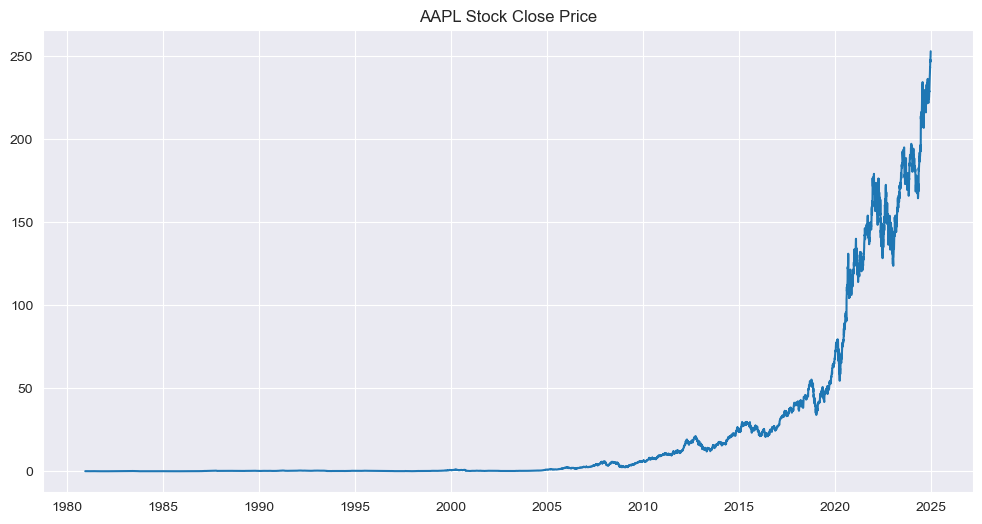

In [6]:
plt.figure(figsize=(12,6))
plt.plot(data.index, data['Close'])
plt.title('AAPL Stock Close Price')
plt.show()

### Adding Technical Indicators to Dataset

On Balance Volume: A momentum indicator that measures positive and negative volume flow - using volume changes to make price predictions. Shows crowd sentiment. https://www.investopedia.com/terms/o/onbalancevolume.asp

Accumulation/Distribution Indicator (A/D): A cumulative indicator that uses volume and price to assess whether a stock is being accumulated or distributed. Seeks to identify divergences between the stock price and volume flow. https://www.investopedia.com/terms/a/accumulationdistribution.asp

Average Directional Index: Measures the strength and momentum of a trend. When the ADX is above 40, the trend is considered to have a lot of directional strength. https://www.investopedia.com/terms/a/adx.asp

RSI: The relative strength index (RSI) measures the speed and magnitude of a stock's price changes to help identify overbought or oversold conditions.

Bollinger Bands: Helps gauge volatility of stocks and identify over or undervalued prices.

Garman-Klass Volatility: Volatility index that consists of using the returns of the open, high, low and closing prices in its calculation.

Average True Range (ATR): Volatility indicator derived from the 14 day simple moving average of a series of true range indicators. https://www.investopedia.com/terms/a/atr.asp 

Moving Average Convergence/Divergence (MACD): Shows the relationship between 2 exponential moving averages (EMAs) of a stock's price. It is calculated by subtracting the 26-period EMA from the 12-period EMA. https://www.investopedia.com/terms/m/macd.asp

In [6]:
def technical_indicators(dataframe):
    dataframe['Garman_Klass_Volatility'] = ((np.log(dataframe['High'])-np.log(dataframe['Low']))**2)/2-(2*np.log(2)-1)*((np.log(dataframe['Close'])-np.log(dataframe['Open']))**2)
    dataframe['RSI'] = ta.rsi(close=dataframe['Close'], length=14)
    dataframe['BB_Low'] = ta.bbands(close=dataframe['Close'], length=20).iloc[:,0]
    dataframe['BB_Mid'] = ta.bbands(close=dataframe['Close'], length=20).iloc[:,1]
    dataframe['BB_High'] = ta.bbands(close=dataframe['Close'], length=20).iloc[:,2]
    dataframe['EMA_50'] = ta.ema(dataframe['Close'], length=50)
    dataframe['EMA_200'] = ta.ema(dataframe['Close'], length=200)
    dataframe['MACD_12_26_9'] = ta.macd(dataframe['Close'], fast=12, slow=26, signal=9).iloc[:,0]
    dataframe['ATR'] = ta.atr(dataframe['High'], dataframe['Low'], dataframe['Close'])
    dataframe['ADI'] = ta.ad(dataframe["High"], dataframe["Low"], dataframe["Close"], dataframe["Volume"])
    dataframe['ADX_14'] = ta.adx(dataframe["High"], dataframe["Low"], dataframe["Close"], length=14).iloc[:,2]
    dataframe['OBV'] = ta.obv(dataframe["Close"], dataframe["Volume"])

    return dataframe

In [7]:
data = technical_indicators(data)

In [8]:
data = data.loc['2010-01-01':].copy()

In [10]:
data.shape

(3765, 17)

In [30]:
data

,Open,High,Low,Close,Volume,Garman_Klass_Volatility,RSI,BB_Low,BB_Mid,BB_High,EMA_50,EMA_200,MACD_12_26_9,ATR,ADI,ADX_14,OBV
Date,,,,,,,,,,,,,,,,,
2010-01-04 00:00:00-05:00,6.429940,6.462175,6.398307,6.447413,493729600,0.000046,67.302476,5.555956,6.027340,6.498725,5.968023,5.097681,0.118289,0.126246,1.796078e+10,15.726401,1.451641e+11
2010-01-05 00:00:00-05:00,6.465188,6.495014,6.424517,6.458560,601904800,0.000059,67.650263,5.561967,6.059064,6.556161,5.987260,5.111222,0.129168,0.122264,1.794020e+10,15.078705,1.457660e+11
2010-01-06 00:00:00-05:00,6.458559,6.484167,6.349199,6.355827,552160000,0.000122,61.190470,5.609082,6.092233,6.575385,6.001713,5.123607,0.128025,0.123172,1.744227e+10,18.266254,1.452139e+11
2010-01-07 00:00:00-05:00,6.379326,6.386858,6.297983,6.344077,477131200,0.000086,60.479134,5.660246,6.123430,6.586613,6.015139,5.135751,0.124733,0.120722,1.746006e+10,20.336059,1.447367e+11
2010-01-08 00:00:00-05:00,6.335641,6.386857,6.298285,6.386254,447610800,0.000073,62.178703,5.674549,6.144789,6.615029,6.029693,5.148193,0.124097,0.118425,1.790158e+10,19.249657,1.451843e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-11 00:00:00-05:00,247.960007,250.800003,246.259995,246.490005,45205800,0.000153,73.823511,220.588913,235.717999,250.847084,232.318600,213.946929,4.943866,3.640722,4.641657e+10,8.598833,1.637434e+11
2024-12-12 00:00:00-05:00,246.889999,248.740005,245.679993,247.960007,32777500,0.000069,75.484304,221.655317,236.859999,252.064682,232.931989,214.285367,5.106705,3.599242,4.643264e+10,9.227688,1.637762e+11
2024-12-13 00:00:00-05:00,247.820007,249.289993,246.240005,248.130005,33155300,0.000075,75.676498,222.438269,237.855499,253.272729,233.527989,214.622130,5.189651,3.560010,4.644057e+10,8.662996,1.638094e+11


In [33]:
data.tail()

,Open,High,Low,Close,Volume,Garman_Klass_Volatility,RSI,BB_Low,BB_Mid,BB_High,EMA_50,EMA_200,MACD_12_26_9,ATR,ADI,ADX_14,OBV
Date,,,,,,,,,,,,,,,,,
2024-12-11 00:00:00-05:00,247.960007,250.800003,246.259995,246.490005,45205800,0.000153,73.823511,220.588913,235.717999,250.847084,232.318600,213.946929,4.943866,3.640722,4.641657e+10,8.598833,1.637434e+11
2024-12-12 00:00:00-05:00,246.889999,248.740005,245.679993,247.960007,32777500,0.000069,75.484304,221.655317,236.859999,252.064682,232.931989,214.285367,5.106705,3.599242,4.643264e+10,9.227688,1.637762e+11
2024-12-13 00:00:00-05:00,247.820007,249.289993,246.240005,248.130005,33155300,0.000075,75.676498,222.438269,237.855499,253.272729,233.527989,214.622130,5.189651,3.560010,4.644057e+10,8.662996,1.638094e+11
2024-12-16 00:00:00-05:00,247.990005,251.380005,247.649994,251.039993,51694800,0.000054,78.747864,223.905497,239.157499,254.409501,234.214735,214.984497,5.427631,3.572153,4.648284e+10,8.016866,1.638611e+11
2024-12-17 00:00:00-05:00,250.134995,253.634995,249.789993,252.850006,24038066,0.000072,80.405238,224.934637,240.398999,255.863361,234.945530,215.361268,5.696618,3.591642,4.649706e+10,7.403838,1.638851e+11


#### Exponential Moving Average (EMA)

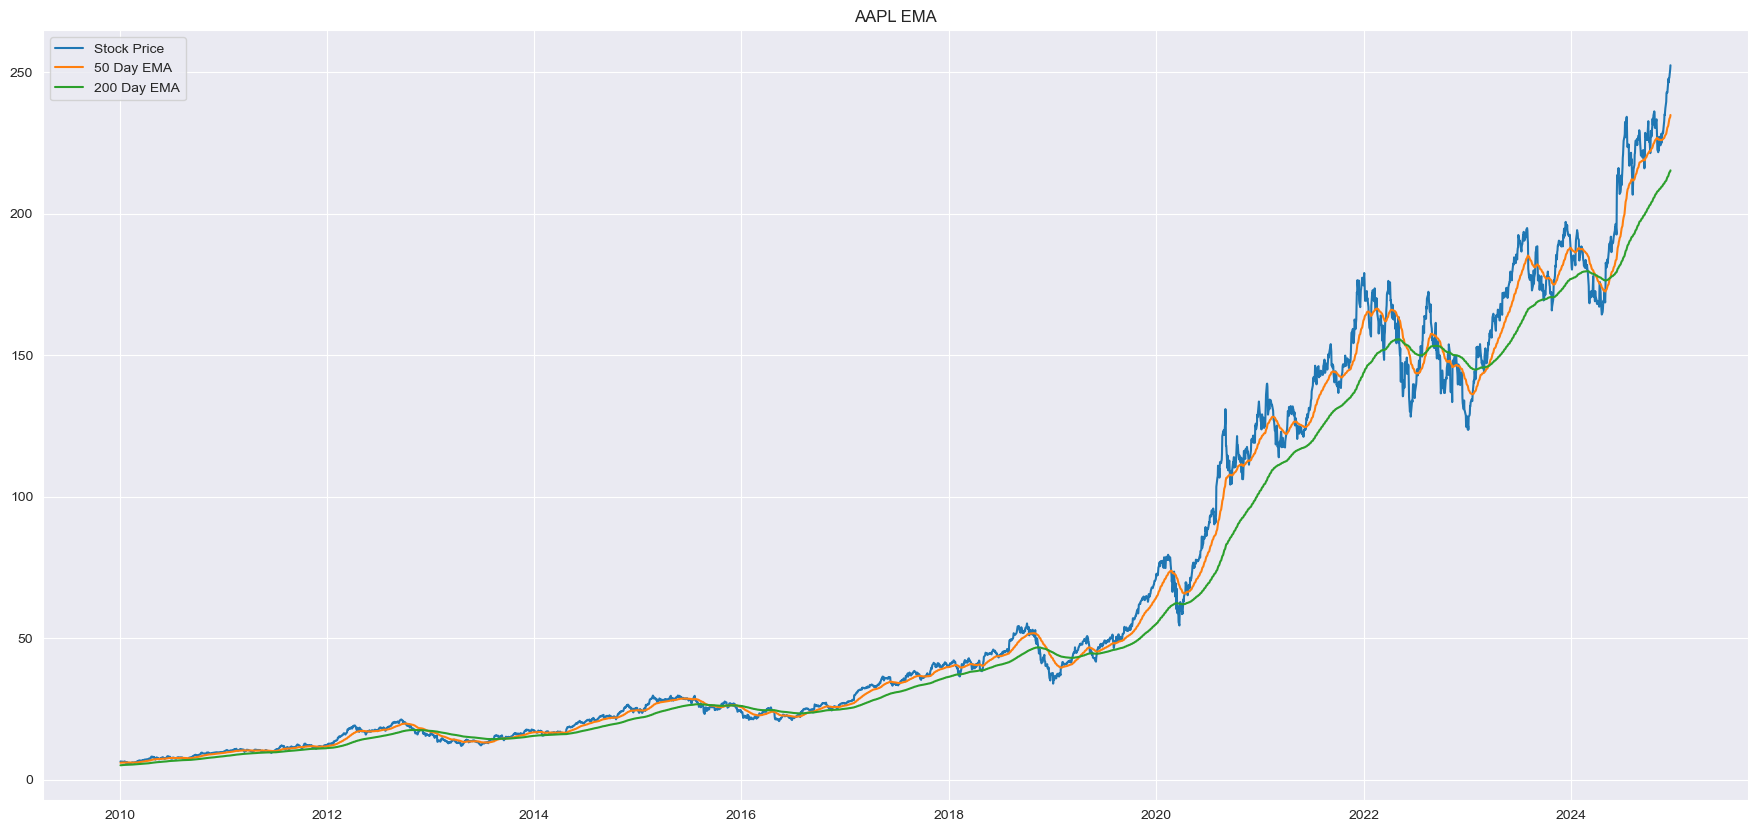

In [12]:
plt.figure(figsize=(22,10))
plt.plot(data.index, data['Close'], label='Stock Price')
plt.plot(data.index, data['EMA_50'], label='50 Day EMA')
plt.plot(data.index, data['EMA_200'], label='200 Day EMA')
plt.title('AAPL EMA')
plt.legend()
plt.show()

#### MACD

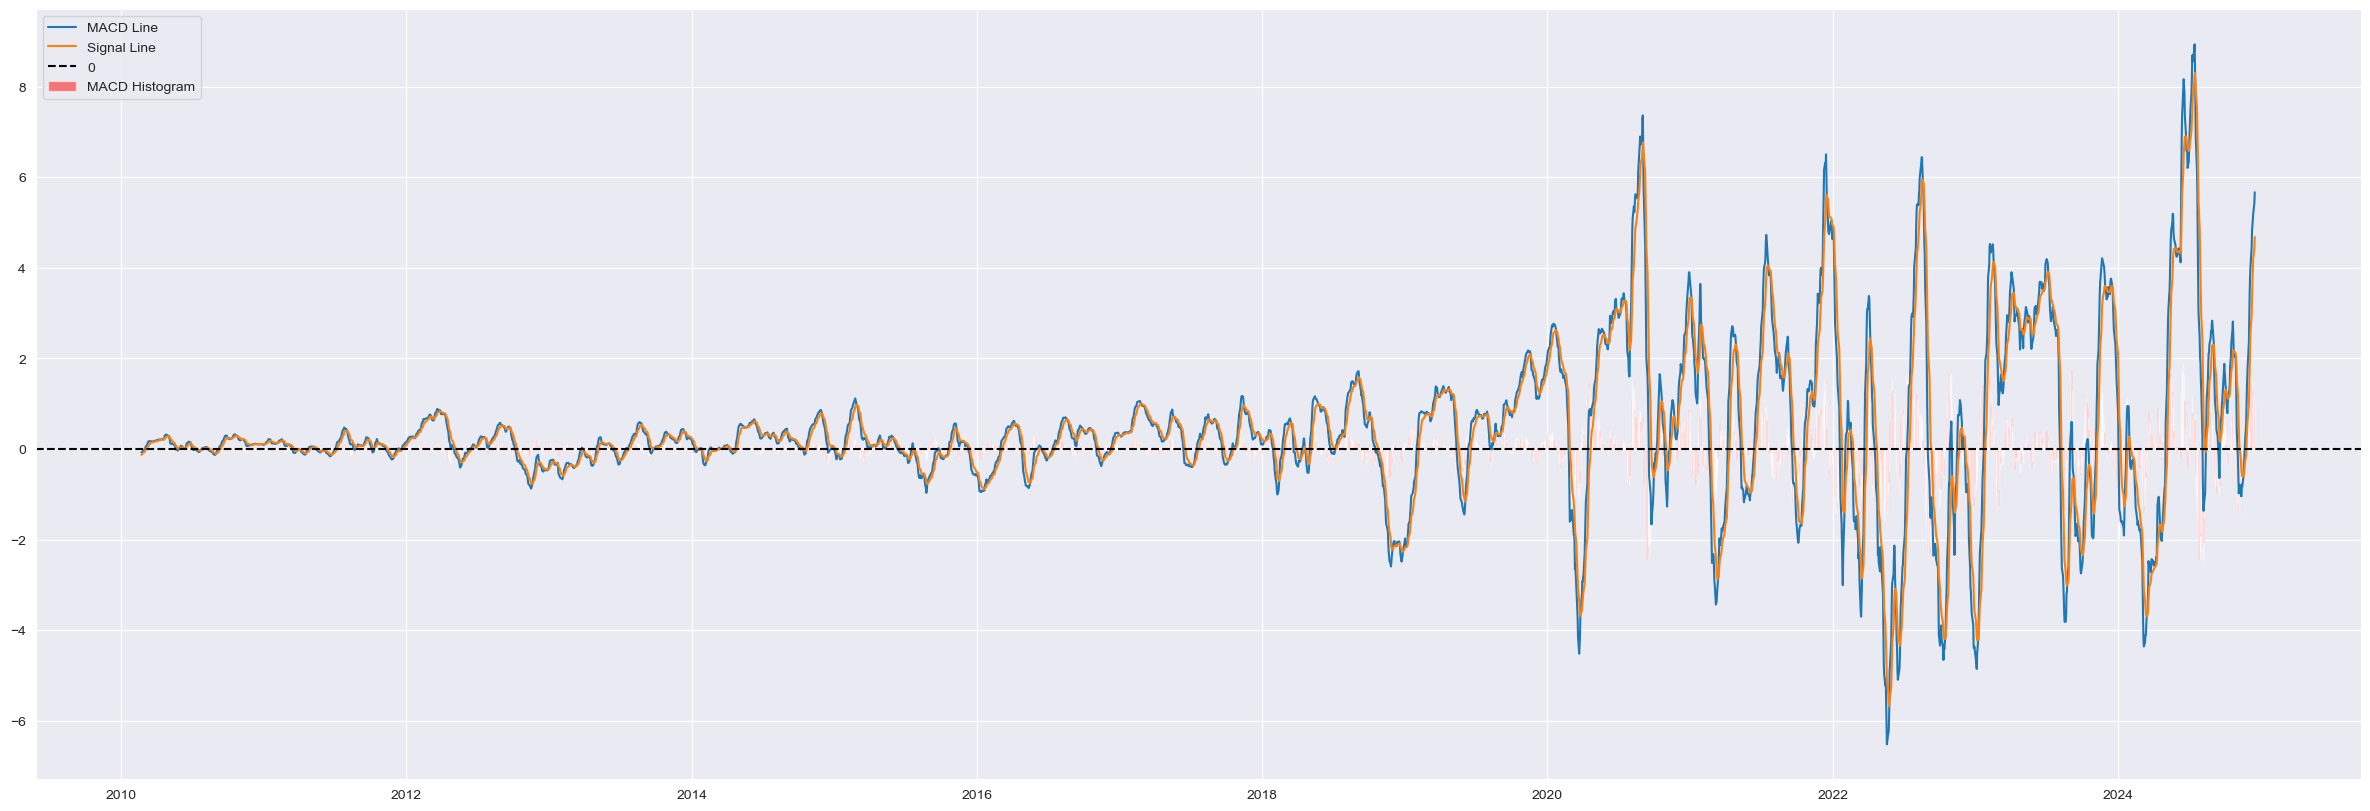

In [13]:
macd = ta.macd(data['Close'], fast=12, slow=26, signal=9)
macd.dropna(inplace=True)

plt.figure(figsize=(30,10))
plt.plot(macd.index, macd['MACD_12_26_9'], label='MACD Line')
plt.plot(macd.index, macd['MACDs_12_26_9'], label='Signal Line')
plt.bar(macd.index, macd['MACDh_12_26_9'], label='MACD Histogram', color='red', alpha=0.5)
plt.axhline(y=0, color='black', linestyle='--', label='0')
plt.legend()
plt.show()

#### RSI

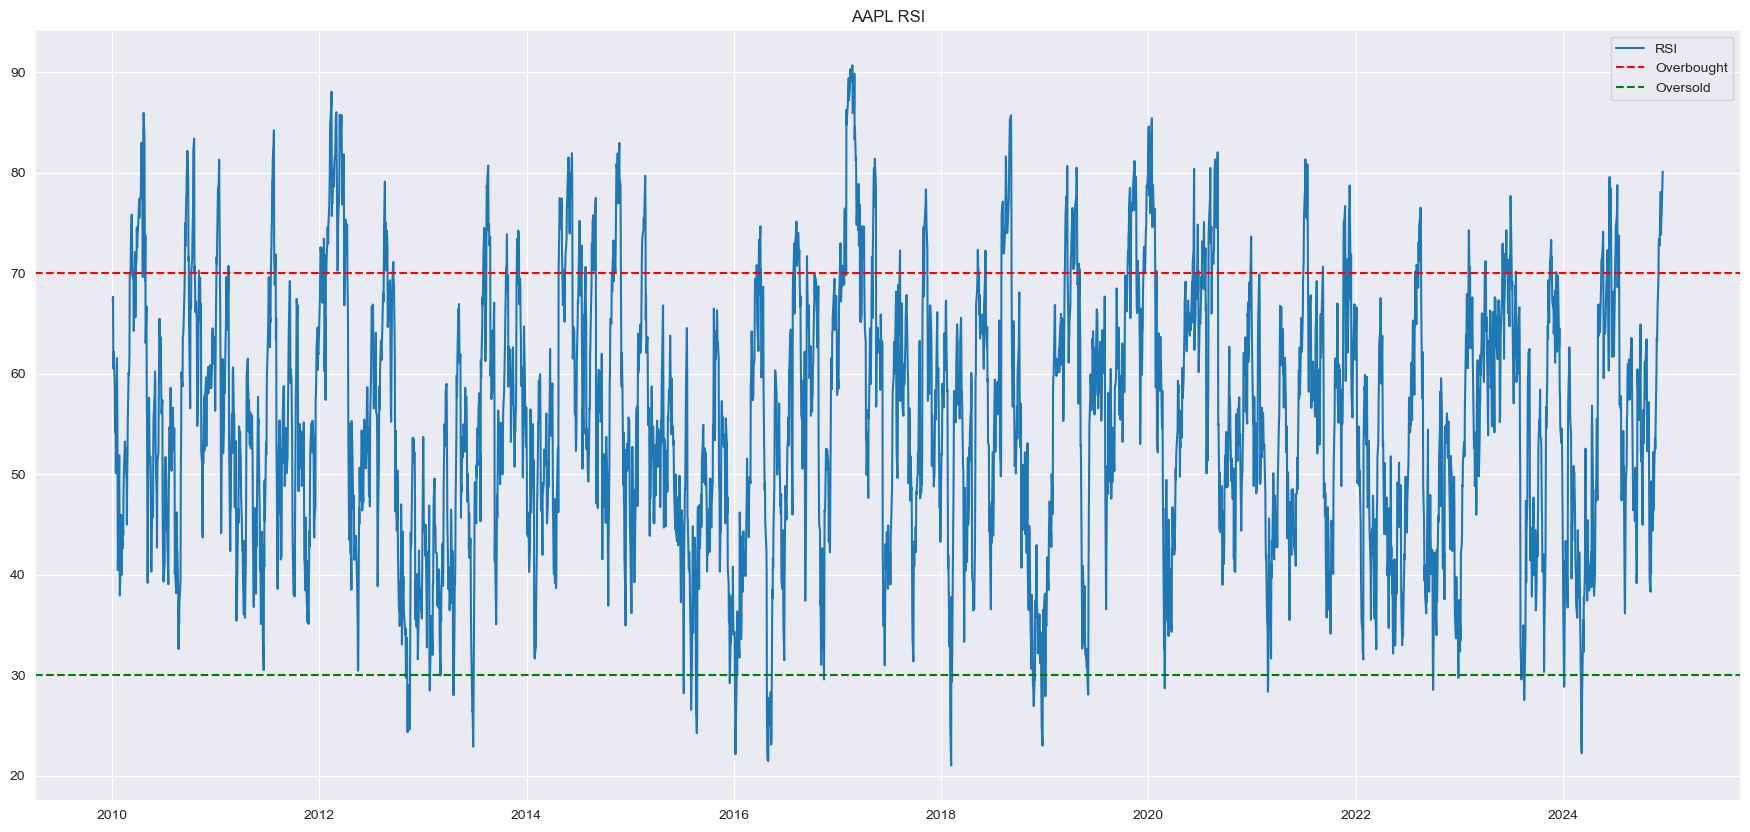

In [14]:
plt.figure(figsize=(22,10))
plt.plot(data.index, data['RSI'], label='RSI')
plt.axhline(70, linestyle='--', color='red', label='Overbought')
plt.axhline(30, linestyle='--', color='green', label='Oversold')
plt.title('AAPL RSI')
plt.legend()
plt.show()

### Data Preprocessing

In [9]:
target = pd.DataFrame(data['Close'])
features = pd.DataFrame(data.drop(columns=['Close']))

In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
feature_transform = scaler.fit_transform(features)

In [11]:
feature_transform = pd.DataFrame(data=feature_transform, index=data.index)

In [12]:
feature_transform.shape

(3768, 16)

In [13]:
from sklearn.model_selection import TimeSeriesSplit

timesplit= TimeSeriesSplit(n_splits=10)
for train_index, test_index in timesplit.split(feature_transform):
        X_train, X_test = feature_transform[:len(train_index)], feature_transform[len(train_index): (len(train_index)+len(test_index))]
        y_train, y_test = target[:len(train_index)].values.ravel(), target[len(train_index): (len(train_index)+len(test_index))].values.ravel()

In [14]:
train_X = np.array(X_train)
test_X = np.array(X_test)
X_train = train_X.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = test_X.reshape(X_test.shape[0], 1, X_test.shape[1])

In [15]:
X_train.shape

(3426, 1, 16)

### Model Development

In [16]:
model = Sequential()
model.add(LSTM(units = 32, activation = 'relu', return_sequences = True, input_shape=(1, train_X.shape[1])))
model.add(Dropout(0.2))

model.add(LSTM(units = 64, activation = 'relu', return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 96, activation = 'relu', return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(units = 128, activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 1, activation='linear'))

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 32)          │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 1, 96)          │        61,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1, 96)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │       115,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 208,257 (813.50 KB)

 Trainable params: 208,257 (813.50 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])

In [19]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5021.3633 - mean_absolute_error: 49.6296
Epoch 2/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 401.2110 - mean_absolute_error: 13.2428
Epoch 3/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 311.1809 - mean_absolute_error: 11.7778
Epoch 4/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 277.1375 - mean_absolute_error: 10.8699
Epoch 5/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 216.2448 - mean_absolute_error: 9.7026
Epoch 6/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 206.4098 - mean_absolute_error: 9.4046
Epoch 7/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 182.4064 - mean_absolute_error: 8.9495
Epoch 8/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 160.6212 - mean_absolute_error: 8.1079
Epoch 9/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 128.6325 - mean_absolute_error: 7.3849
Epoch 10/100
108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 118.0168 - mean_absolute_error: 7

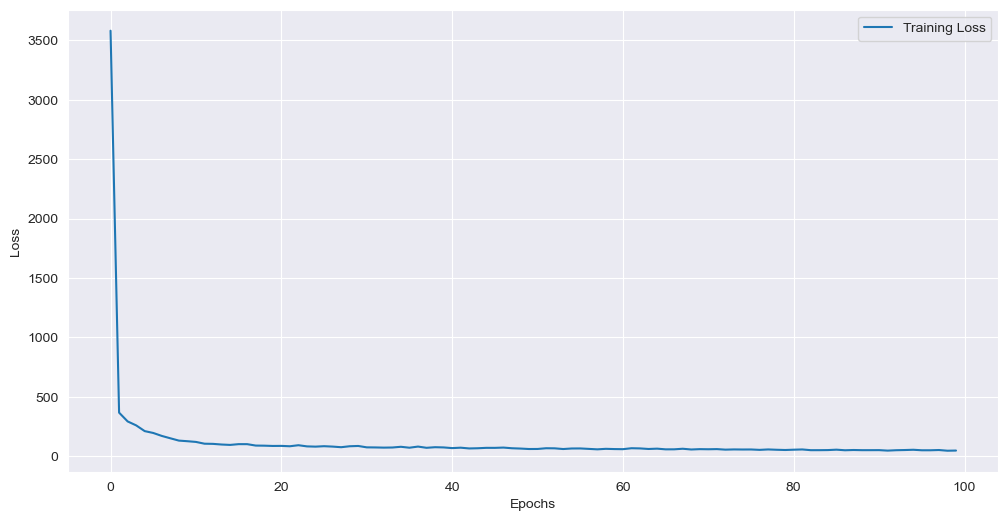

In [20]:
plt.figure(figsize=(12,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Model Evaluation

In [21]:
y_pred = model.predict(X_test)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


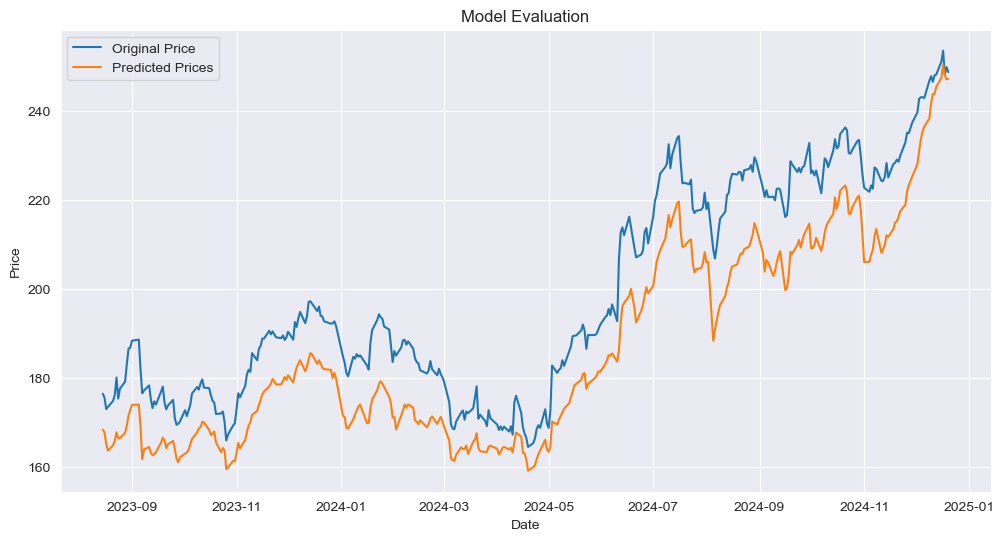

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(y_test):], y_test, label='Original Price')
plt.plot(data.index[-len(y_test):], y_pred, label='Predicted Prices')
plt.title('Model Evaluation')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

### Forecasting

In [23]:
def forecast_next_days(model, feature_transform, target, forecast_days=30):
    # Get the last sequence of features
    last_sequence = feature_transform.iloc[-1:].values
    last_sequence = last_sequence.reshape(1, 1, -1)
    
    # Get the last known close price
    last_close = target.iloc[-1].values[0]
    
    # List to store predictions
    predictions = []

    predictions.append(last_close)
    
    for _ in range(forecast_days - 1):
        # Predict the next day's price
        next_pred = model.predict(last_sequence, verbose=0)
        next_price = next_pred[0, 0]
        predictions.append(next_price)
        
        # Create a new sequence for the next prediction
        # Add some small random variation to prevent static predictions
        new_sequence = last_sequence[0, 0, :].copy()
        
        # Add a small amount of noise to features
        noise = np.random.normal(0, 0.01, new_sequence.shape)
        new_sequence += noise
        
        # Reshape for next prediction
        last_sequence = new_sequence.reshape(1, 1, -1)

    
    return predictions

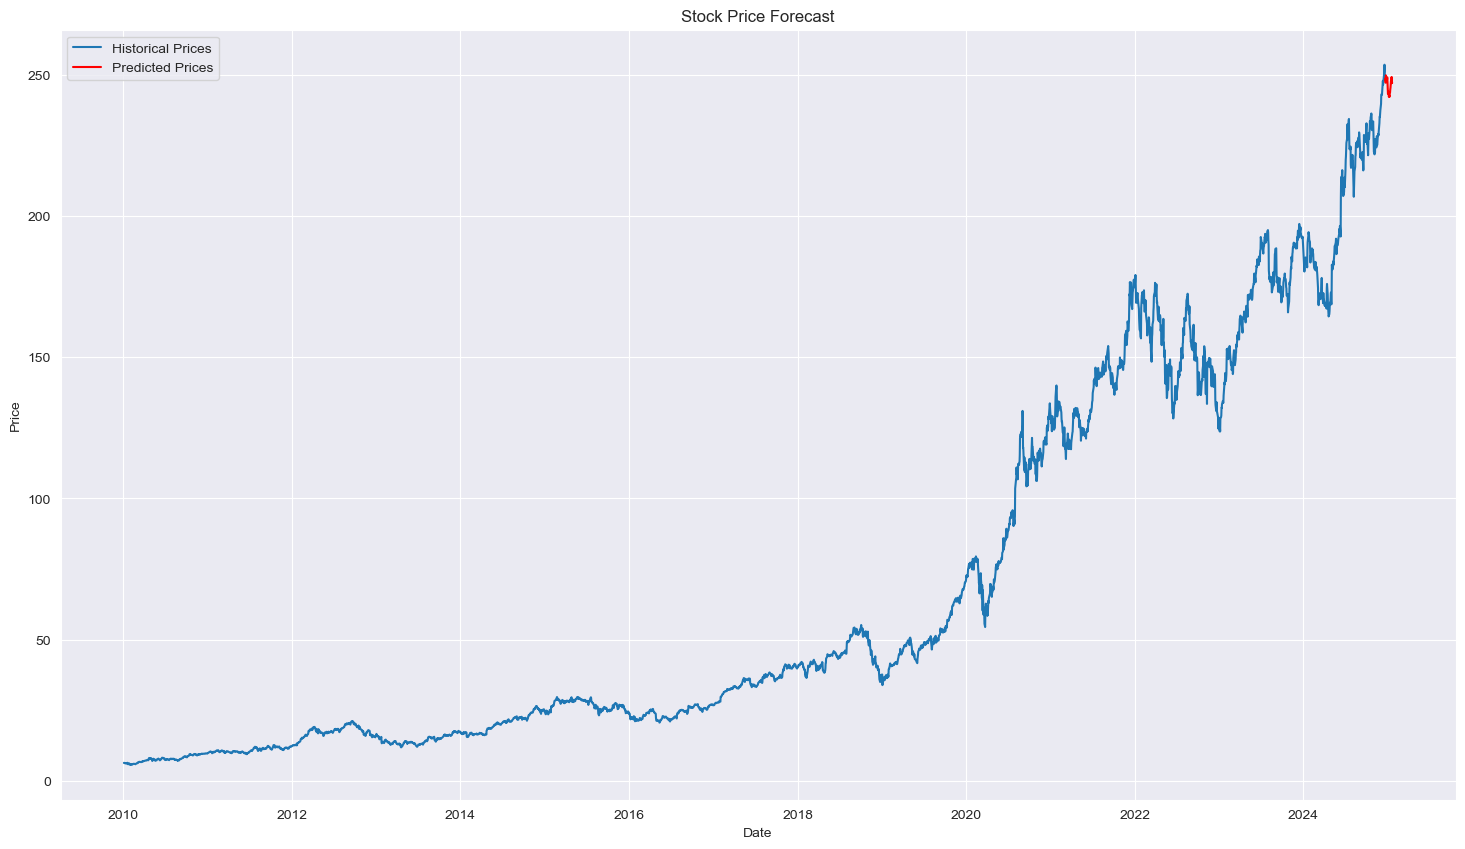

In [24]:
# Forecast the next 30 days
predictions = forecast_next_days(model, feature_transform, target, forecast_days=30)

# Create a time series of predictions
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
predictions_series = pd.Series(predictions, index=future_dates)

# Visualize the predictions
plt.figure(figsize=(18,10))
plt.plot(data['Close'], label='Historical Prices')
plt.plot(predictions_series, label='Predicted Prices', color='red')
plt.title('Stock Price Forecast')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [25]:
import plotly.graph_objects as go


last_month_data = data[data.index >= (data.index[-1] - pd.DateOffset(months=1))]

# Create a time series of predictions
last_date = data.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)
predictions_series = pd.Series(predictions, index=future_dates)

# Create the plot
fig = go.Figure()

# Add historical prices to the plot
fig.add_trace(go.Scatter(x=last_month_data.index, y=last_month_data['Close'], mode='lines', name='Historical Prices'))

# Add predicted prices to the plot
fig.add_trace(go.Scatter(x=predictions_series.index, y=predictions_series, mode='lines', name='Predicted Prices', line=dict(color='red')))

# Add title and labels
fig.update_layout(
    title='Stock Price Forecast',
    xaxis_title='Date',
    yaxis_title='Price',
    legend_title='Legend',
    template='plotly_dark'
)

# Show the plot
fig.show()

In [27]:
predictions_series = pd.DataFrame(predictions_series, columns=['Forecasted Close Price'])

In [28]:
model.save('forecast_model.h5')